Честно говоря, мне не вполне понятно задание. 

Если мы хотим максимально приблизить исходные данные, мы можем просто взять, например, MA1 - её линия будет полностью повторять график, а ошибка будет равна нулю. Однако смысла в этом не очень много.

Поэтому я подошел к заданию иначе - я не приближал исходные ряды, а оценивал прогностическую способность различных моделей. В конце-концов, ради этого всё и затевается, насколько я понимаю.

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
airlines_passengers = pd.read_csv("../01. Знакомство с временными рядами/Series/international-airline-passengers.csv")

### Нестационарный ряд

In [51]:
series = airlines_passengers["Count"]

In [52]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [53]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [54]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [55]:
def plot_tema(ser, ser_to_plot, alpha, beta, gamma, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

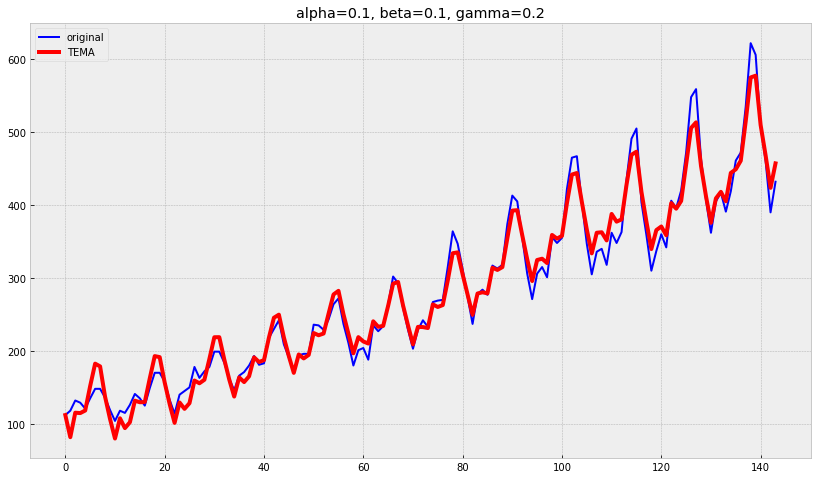

In [56]:
plot_tema(series, series, 0.1, 0.1, 0.2, n_preds=0)

In [57]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [58]:
train, test, val = series[:60], series[60:70], series[70:]

In [59]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [60]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [61]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 175.55253688386273
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-57.51529955,  -0.16771366,  10.57049985])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 852
      nit: 141
     njev: 213
   status: 0
  success: True
        x: array([0.00248021, 0.94600612, 0.        ])


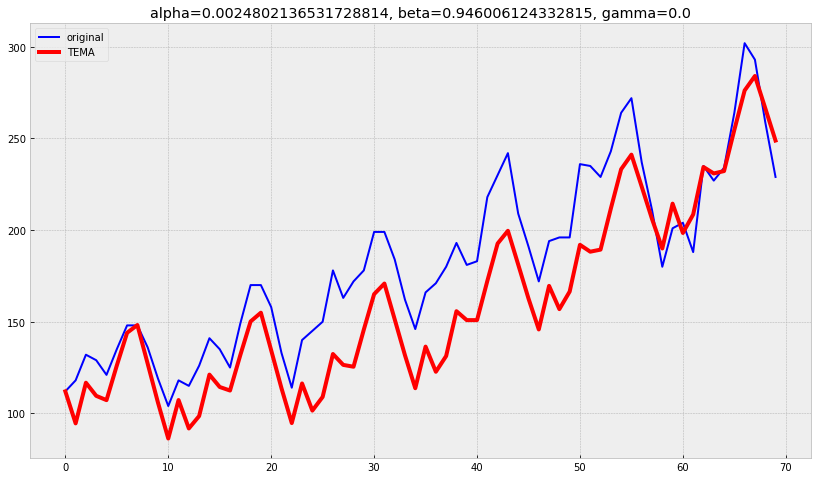

In [68]:
plot_tema(ser=train, ser_to_plot=series[:70], alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt, n_preds=len(test))

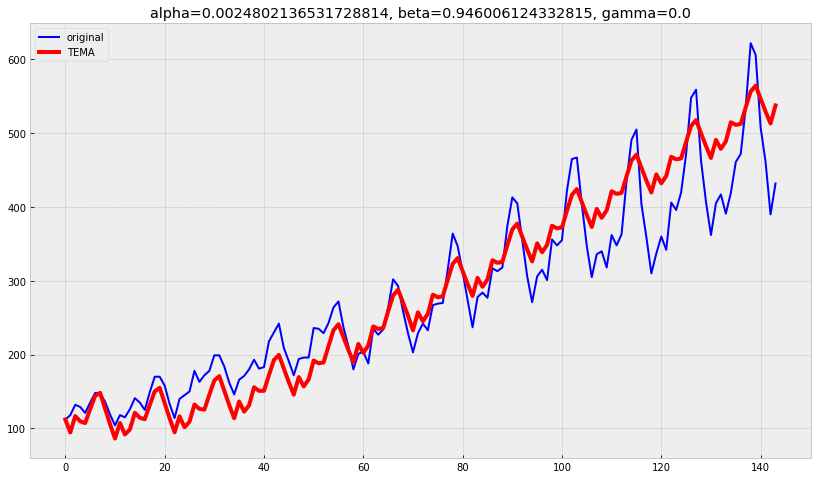

In [70]:
plot_tema(ser=series[:70], ser_to_plot=series, alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt, n_preds=len(val))

Метод Хольт-Винтерс был выбран т.к. он учитывает сезонность, что актуально для рассматриваемого временного ряда.  
Несмотря на то, что в прогнозе неплохо учтены тренд, сезонность и общая форма "пиков", никак не учитывается увеличивающаяся со временем дисперсия.  
Тем не менее, это, вероятно, лучшее, на что в данном случае приходится рассчитывать, говоря о прогностической силе метода класса MA.

### Cтационарный ряд

In [77]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [72]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [73]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


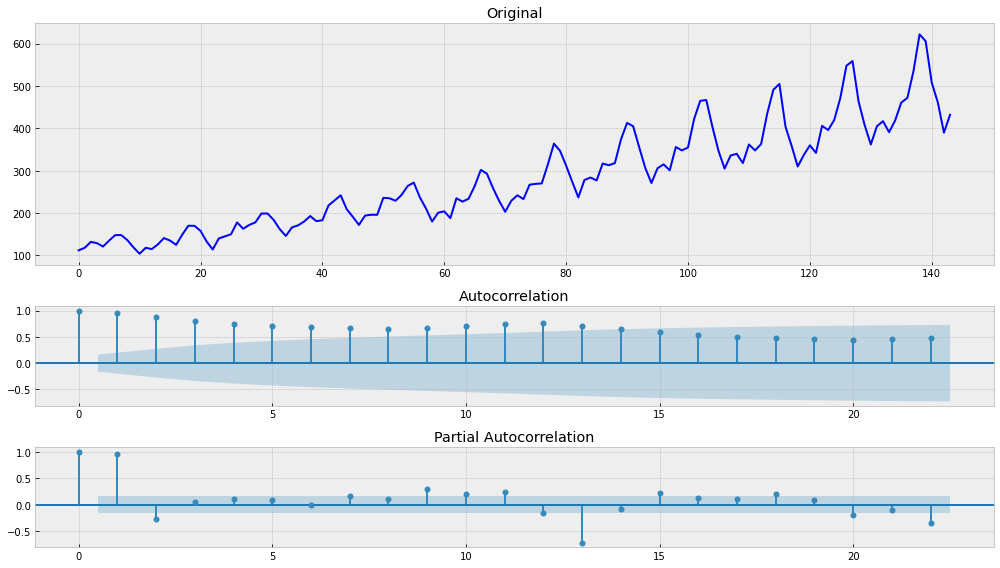

In [78]:
series = airlines_passengers['Count']

tsplot(series)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


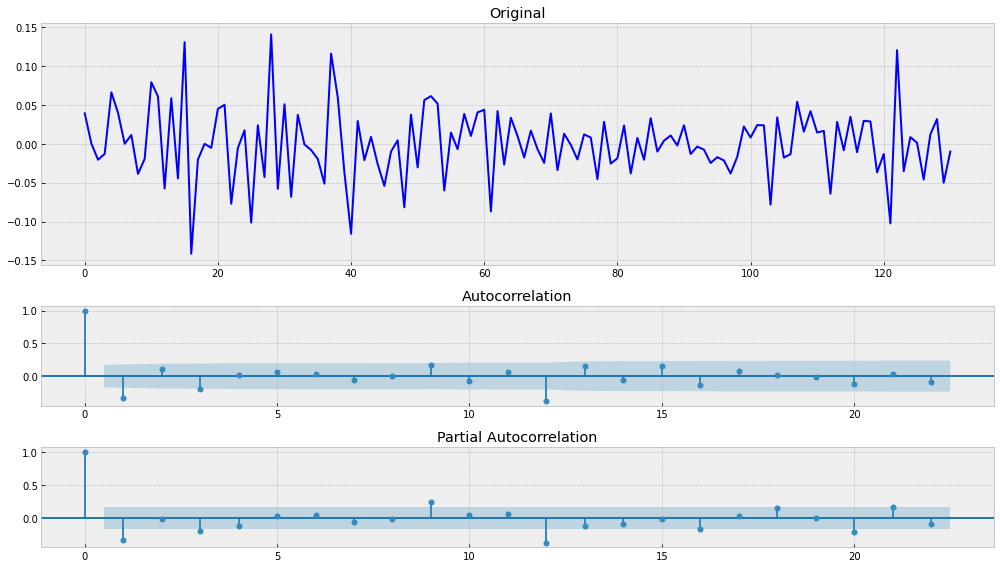

In [79]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]
series = series[12:] - series[:-12]

tsplot(series)

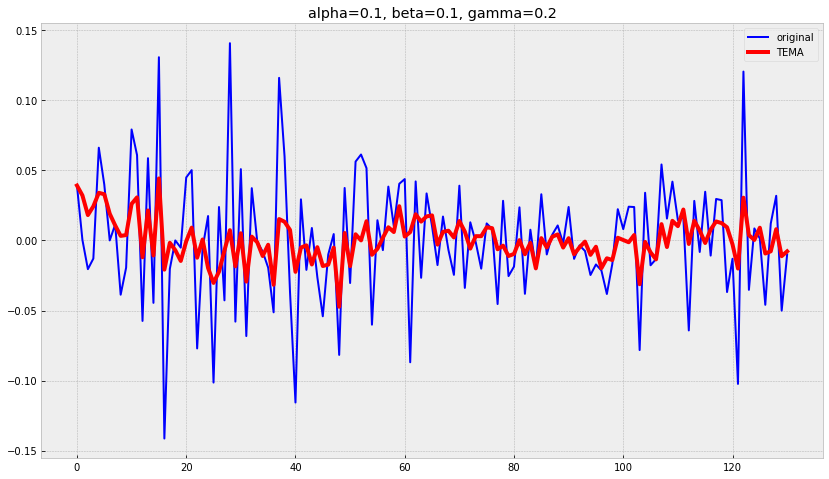

In [80]:
plot_tema(series, series, 0.1, 0.1, 0.2, n_preds=0)

In [81]:
train, test, val = series[:60], series[60:70], series[70:]

In [82]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [83]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.002328428299811667
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.40805783e-03, 4.90156093e-05, 4.44113409e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 360
      nit: 54
     njev: 90
   status: 0
  success: True
        x: array([0.00606195, 0.1405629 , 0.        ])


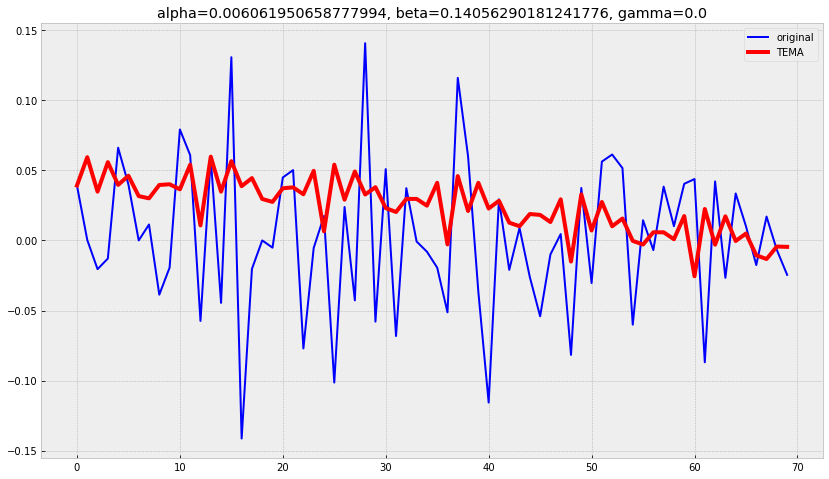

In [84]:
plot_tema(ser=train, ser_to_plot=series[:70], alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt, n_preds=len(test))

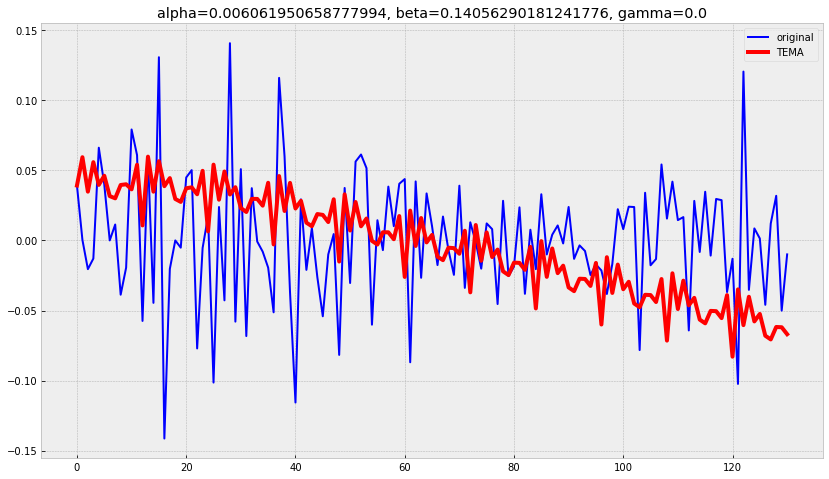

In [100]:
plot_tema(ser=series[:70], ser_to_plot=series, alpha=alpha_opt, beta=beta_opt, gamma=gamma_opt, n_preds=len(val))

Модель неплохо приближает полный исходный ряд.

Однако прогнозирование работает не так хорошо.  
Ряд является стационарным, а потому мат. ожидание его значений равно нулю. Но модель, не зная об этом, определила нисходящий тренд, что является ошибкой.  

Попробуем взять что-нибудь попроще, благо в стационарном ряде полностью отсутствует сезонность и тренд, а значит мы можем снизить требования к модели.

In [121]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

In [122]:
series_pred = predict(pd.Series(train), 20, 70)

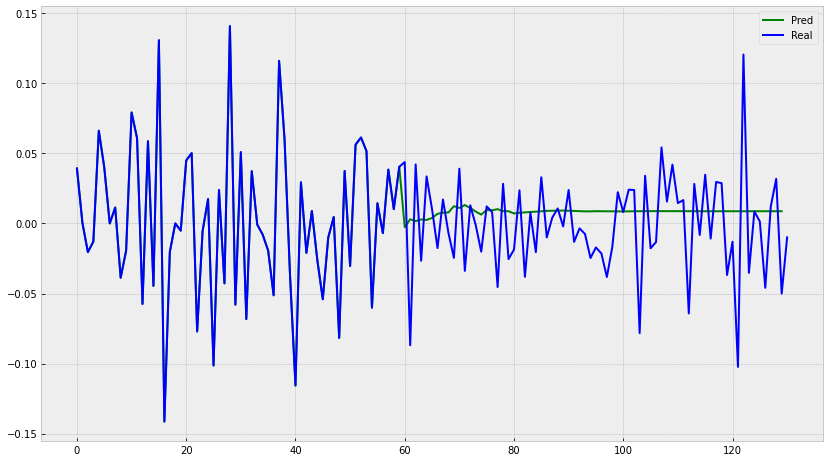

In [128]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='2', label='Pred')
    plt.plot(series, color='blue', linewidth='2', label='Real')
    plt.legend()

Как ни странно, примитивная модель лучше прогнозирует отсутствующие значения.